In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM

from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist

from MulticoreTSNE import MulticoreTSNE as TSNE
from tqdm import tqdm_notebook

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def data_loader(n, path_attacks='datasets/data/attacks/', path_logins='datasets/data/logins/'):
    """Loads data, given id"""
    files_attacks = os.listdir(path='datasets/data/attacks/')
    files_attacks = [f for f in files_attacks if '.csv' in f]
    files_attacks = [f for f in files_attacks if f.split('-')[0] == str(n)]
    
    login_data = pd.read_csv(path_logins+f'{n}.csv')
    
    attack_data = pd.DataFrame()
    for f in files_attacks:
        attack_data = pd.concat([attack_data, pd.read_csv(path_attacks+f)], axis=0)
    
    return login_data, attack_data


class scaler_df(MinMaxScaler):
    """Wrapper for default scalers to procedure dataframe results"""
    def transform(self, x):
        z = super(scaler_df, self).transform(x)
        return pd.DataFrame(z, index=x.index, columns=x.columns)

def plot_confusion(trunc_labels, preds):
    cm = confusion_matrix(true_labels, preds)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: Original',
                                                 'Predicted: Attacker'],
                                                 index=['Actual: Original', 'Actual: Attacker'])
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False);

In [3]:
login_data, attack_data = data_loader(4)

In [4]:
login_data.head()

,S,S,o,o.1,p,p.1,p.2,p.3,a,a.1,...,u,u.1,s,s.1,i,i.1,s.2,s.3,1,1.1
0,0,8,624,629,1054,1059,1260,1263,1625,1628,...,3144,3156,3607,3611,3767,3770,3941,3946,4565,4571
1,0,12,568,576,1033,1041,1260,1263,1817,1821,...,3782,3787,4316,4324,4703,4708,5192,5221,6064,6067
2,0,5,499,503,1546,1551,1731,1734,2130,2136,...,4119,4121,4685,4688,5231,5235,5844,5847,6490,6493
3,0,10,738,785,1323,1333,1500,1508,2198,2201,...,3566,3570,4187,4190,4662,4665,5080,5087,5675,5679
4,0,3,531,536,936,939,1135,1139,1585,1588,...,4741,4749,5307,5310,5688,5690,6221,6225,6889,6892


In [5]:
attack_data.head()

,S,S,o,o.1,p,p.1,p.2,p.3,a,a.1,...,u,u.1,s,s.1,i,i.1,s.2,s.3,1,1.1
0,0,6,257,264,525,533,691,698,1325,1331,...,2291,2298,2474,2480,2590,2597,2754,2761,4191,4195
1,0,9,300,307,570,578,752,759,1169,1176,...,1952,1959,2116,2123,2250,2259,2369,2375,3101,3107
2,0,9,450,457,720,727,887,895,1203,1209,...,2045,2051,2219,2226,2349,2356,2499,2506,3935,3941
3,0,11,395,402,663,669,813,818,1028,1034,...,1679,1686,1829,1836,1928,1935,2045,2051,2894,2901
4,0,10,384,392,654,661,819,825,1019,1026,...,1870,1877,2084,2090,2183,2189,2349,2355,3449,3455


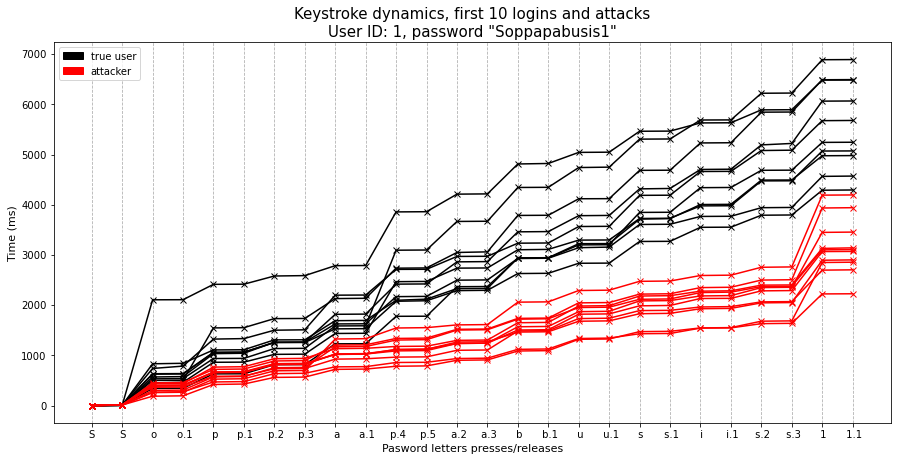

In [6]:
password = ''.join([letter.strip()[0] for letter in login_data.columns][::2])
plt.figure(figsize=(15, 7))
plt.title(f'Keystroke dynamics, first 10 logins and attacks\nUser ID: 1, password "{password}"', size=15)

for i in range(10):
    plt.plot(login_data.iloc[i], 'x-', label=f'login #{i}', color='black')

for i in range(10):
    plt.plot(attack_data.iloc[i], 'x-', label=f'login #{i}', color='red')

plt.ylabel('Time (ms)', size=11)
plt.xlabel('Pasword letters presses/releases', size=11)
plt.grid(axis='x', linestyle='--')

red_patch = mpatches.Patch(color='red', label='attacker')
black_patch = mpatches.Patch(color='black', label='true user')

plt.legend(handles=[black_patch, red_patch])
plt.show()

In [7]:
def feature_transformer(data):
    """Perform feature extraction from a given dataset"""
    # time between press and release
    time_press_release = np.diff(data).T[::2].T
    
    time_press_release = pd.DataFrame(
        time_press_release,
        columns=[f'tpr_{i}' for i in range(time_press_release.shape[1])]
    )
    
    # Average of key hold
    avg_time_key_hold = np.average(time_press_release, axis=1)
    
    avg_time_key_hold = pd.DataFrame(
        avg_time_key_hold,
        columns=['avg_tkh']
    )
    
    # Time between consecutive key presses
    time_consec_key_press = np.diff(data[data.columns[::2]])
    
    time_consec_key_press = pd.DataFrame(
        time_consec_key_press,
        columns=[f'tckp_{i}' for i in range(time_consec_key_press.shape[1])]
    )
    
    # Time between key release and next key press 
    cols = [(data.columns[i], data.columns[i+1]) for i in range(1, len(data.columns)-1, 2)]
    cols = list(sum(cols,()))
    time_key_release_next = np.diff(data[data.columns[::2]])
    
    time_key_release_next = pd.DataFrame(
        time_key_release_next,
        columns=[f'tkrn_{i}' for i in range(time_key_release_next.shape[1])]
    )
    
    preprocessing_data = pd.concat(
        (
            time_press_release,
            avg_time_key_hold,
            time_key_release_next
        ), axis=1
    )
    return preprocessing_data

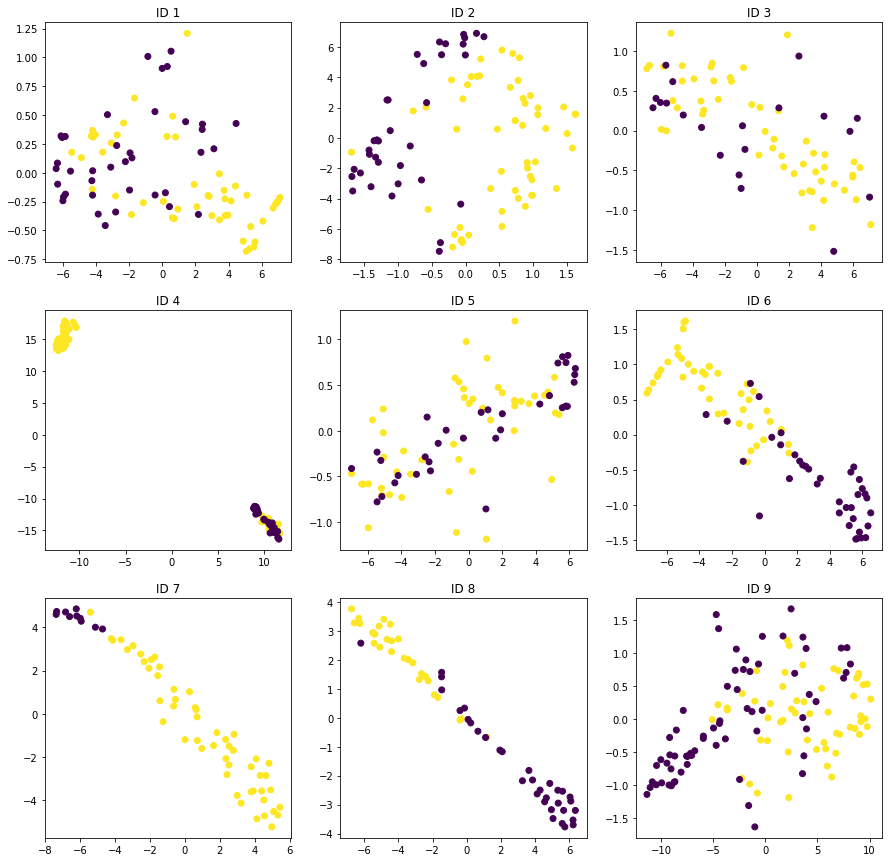

In [8]:
def tsne_preprocessing(login_data, attack_data):
    
    finalscaled = pd.concat([login_data, attack_data])
    tsne = TSNE(n_jobs=-1)
    tsne_representation = tsne.fit_transform(finalscaled)
    labels = np.concatenate((np.ones(len(login_data)), np.zeros(len(attack_data))-1))
    
    return tsne_representation, labels

index = 1
f, axarr = plt.subplots(3, 3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        login_data, attack_data = data_loader(index)
        tsne_representation, labels = tsne_preprocessing(login_data, attack_data)
        
        axarr[i, j].scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=labels)
        axarr[i, j].set_title(f'ID {index}')
        index += 1
        

In [9]:
login_data, attack_data = data_loader(4)
scaler = scaler_df()

scaled_login = scaler.fit_transform(feature_transformer(login_data))
scaled_attack = scaler.transform(feature_transformer(attack_data))

full_df = pd.concat([scaled_login, scaled_attack])

true_labels = np.concatenate(
    [
        np.zeros(shape=scaled_login.shape[0]),
        np.ones(shape=scaled_attack.shape[0])
    ]
)

# Distance based

In [10]:
class DistanceOutliers(BaseEstimator):
    """
    Distance based outlier detector model
    
    Fit method calculates centroid of training samples and
    using `metric` get distances from centroid to train samples.
    Having distances - we calculate `treshold` based on `percentile`.
    
    Predict method uses `treshold` and `metric` to determine, whether
    distance to sample from centroid is too large -> oitlier.
    
    -----
    Parameters
    
    - metric: string, default euclidean
        metric to use fordistance calculation (see scipy.spatial.distance.cdist)
    
    - percentile: frlot in range [0, 100]
        hyperparameter which sets the treshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distance_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.treshold = np.percentile(distance_train, self.percentile)
    
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.treshold).astype(int)
        return predictions

In [11]:
scaler = scaler_df()
euclidian_model = DistanceOutliers(metric='euclidean', percentile=80)

scaled_login = scaler.fit_transform(feature_transformer(login_data))
scaled_attack = scaler.transform(feature_transformer(attack_data))

euclidian_model.fit(scaled_login)

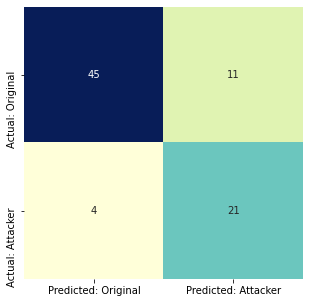

In [12]:
plot_confusion(true_labels, euclidian_model.predict(full_df))

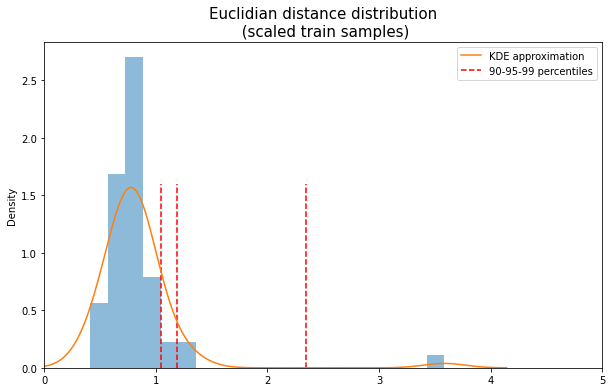

In [13]:
distance_train = cdist(scaled_login.mean(axis=0).values.reshape(-1, 1).T, scaled_login).reshape(-1)
distance_test = cdist(scaled_login.mean(axis=0).values.reshape(-1, 1).T, scaled_attack).reshape(-1)

plt.figure(figsize=(10, 6))

plt.hist(distance_train, density=True, alpha=.5, bins=20)
sns.kdeplot(distance_train, label='KDE approximation')

plt.vlines(
    np.percentile(distance_train, [90, 95, 99]),
    ymin=0, ymax=1.6,
    linestyles='dashed',
    colors='red',
    label='90-95-99 percentiles'
)
plt.title('Euclidian distance distribution\n (scaled train samples)', size=15)
plt.legend()

plt.xlim(0, 5)
plt.show()

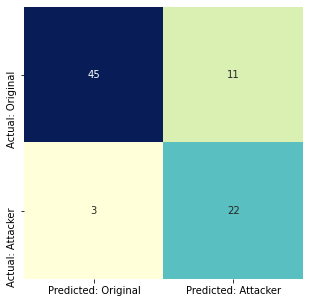

In [14]:
scaler = scaler_df()
euclidian_model = DistanceOutliers(metric='cityblock', percentile=80)  # cityblock Манхэттенское расстояние
euclidian_model.fit(scaled_login)

plot_confusion(true_labels, euclidian_model.predict(full_df))

# Density-based

In [15]:
outlier_percentage = 1

eps = 1e-5

while outlier_percentage > .1:
    model = DBSCAN(eps=eps).fit(scaled_login)
    labels = model.labels_
    labels = np.array([1 if label == -1 else 0 for label in labels])
    outlier_percentage = np.mean(sum(labels==1))
    eps += .005

model = DBSCAN(eps)
model.fit(full_df.values)
predicted_labels = np.array([1 if label == -1 else 0 for label in model.labels_])

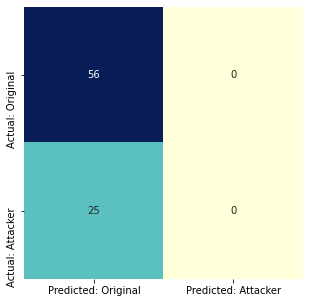

In [16]:
plot_confusion(true_labels, predicted_labels)

# <center>One-Class SVM</center>

## Коротко о Support Vector Machine

In [17]:
model = OneClassSVM(nu=.1)
model.fit(scaled_login)
preds = model.predict(full_df)

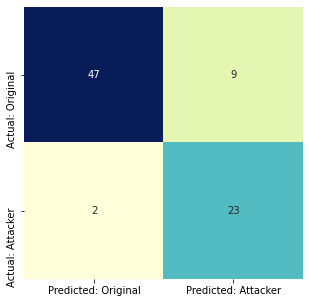

In [18]:
preds = np.array([1 if label == -1 else 0 for label in preds])
plot_confusion(true_labels, preds)

# Isolation Forest

In [20]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, contamination=.2, max_features=.4, bootstrap=True)

model.fit(scaled_login)

preds = model.predict(full_df)
preds = np.array([1 if label == -1 else 0 for label in preds])

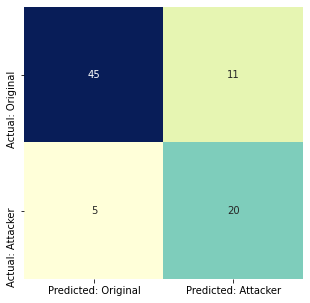

In [21]:
plot_confusion(true_labels, preds)